<a href="https://colab.research.google.com/github/joiceyy/wet-muck-risk-map-analysis/blob/main/GBC_tercinta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#WET MUCK RISK ANALYSIS




## **Utils & Lib**

### import libraries

In [ ]:
# LIBRARY
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from datetime import datetime
from sklearn.metrics import classification_report
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# to show all dataframe field
pd.set_option("display.max_columns", None)

warnings.simplefilter("ignore", category=DeprecationWarning)

### save df to xlsx

In [ ]:
def save_df_to_xlsx(df: pd.DataFrame, filename: str):
  print(f"[save_df_to_xlsx] process save: {filename} !!!")
  # df.to_excel(filename, index=False)

### check_df_column

In [ ]:
def check_df_column(df:pd.DataFrame, columns: list[str]):
  missing_columns = set(columns) - set(df.columns)
  if missing_columns:
      print("Missing columns:", missing_columns)
      return

  print("All columns exist in df!!!")
  return

### date converter utils

In [ ]:
def convert_date_to_year_month(timestamp):
    # Ensure the input is a Pandas Timestamp
    if isinstance(timestamp, pd.Timestamp):
        return timestamp.strftime("%y%m")  # Format as YYMM
    else:
        print(f"Input must be a Pandas Timestamp: {timestamp}")
        return timestamp

def convert_to_year(date_str: str) -> int:
    year_prefix = 2000
    return year_prefix + int(date_str[:2])

def safe_to_datetime(x):
    try:
        return pd.to_datetime(x)
    except:
        return None

### logistic_regression_univariate

In [ ]:
def logistic_regression_univariate(df_to_process: pd.DataFrame, attr: str):
  df = df_to_process.copy()

  print("====================================")
  print(f"Logistic Regression: {attr}")
  print(f"spill size: {len(df[(df['type'] == 'Spill')])}")
  print(f"notype size: {len(df[(df['type'] == 'notype')])}")

  # add type_id as biner value for type, eg: notype -> 0, Spill -> 1
  df['type_id'] = df['type'].map({'notype': 0, 'Spill' : 1})

  X_train, X_test, y_train, y_test = train_test_split(df[[attr]], df['type_id'], test_size=0.3, random_state=42)
  model = LogisticRegression(class_weight='balanced')
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)

  plt.figure(figsize=(8,5))
  sns.scatterplot(x=df[attr], y=df['type_id'], label='Data', alpha=0.6)

  _range = np.linspace(df[attr].min(), df[attr].max(), 100).reshape(-1, 1)
  _range_df = pd.DataFrame(_range, columns=[attr])
  prob = model.predict_proba(_range_df)[:,1]
  plt.plot(_range_df, prob, color='red', label='Sigmoid Curve')
  plt.xlabel(attr)
  plt.ylabel('Probabilitas Spill')
  plt.legend()
  plt.show()

  print(f'Akurasi model: {accuracy:.2f}')

  print(classification_report(y_test, y_pred))

### histogram

In [ ]:
def histogram(df: pd.DataFrame, attributes_data: dict):
  print("=============================")
  print(f"Histogram: {df['dp'].tolist()[0]}")
  attributes = attributes_data['columns']
  colors = attributes_data['colors']
  df_sorted = df.sort_values(by='date').copy()
  dates = df_sorted['date'].tolist()

  values = {col: df_sorted[col].values for col in attributes}
  # print(values)
  fig, ax = plt.subplots(figsize=(13, 5))
  bottom = np.zeros(len(dates))

  for attr, color in zip(attributes, colors):
      ax.bar(dates, values[attr], bottom=bottom, label=attr, color=color)
      bottom += values[attr]

  ax.set_xlabel("Date")
  ax.set_ylabel("Percentage")
  ax.set_ylim(0, 100)
  ax.set_title(f"{df['pb'].tolist()[0]}: {df['dp'].tolist()[0]}")
  ax.legend()
  plt.yticks(np.arange(0, 101, 10))  # 0 to 100, step by 10
  plt.xticks(rotation=45)
  plt.xticks(rotation=45)

  plt.show()

### boxplot

In [ ]:
def boxplot(df: pd.DataFrame, field_name: str):
  plt.figure(figsize=(6, 4))
  sns.boxplot(y=df[field_name])
  plt.title(f'{field_name}')
  plt.show()

### IQR

In [ ]:
def iqr(df: pd.DataFrame, field_name: str):
  Q1 = df[field_name].quantile(0.25)
  Q3 = df[field_name].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  outliers = df[(df[field_name] < lower_bound) | (df[field_name] > upper_bound)]
  print(outliers[field_name])
  print("================================")

### before and after boxplot/iqr

In [ ]:
def before_after_boxplot_iqr(df_candidate: pd.DataFrame, field_name: str):
  df = df_candidate.copy()
  Q1 = df[field_name].quantile(0.25)
  Q3 = df[field_name].quantile(0.75)
  IQR = Q3 - Q1

  # Define bounds
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Filter out outliers
  df_filtered = df[(df[field_name] >= lower_bound) & (df[field_name] <= upper_bound)]

  # Plot Boxplot Before and After Removing Outliers
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  sns.boxplot(y=df[field_name])
  plt.title(f"Before Removing Outliers: {field_name}")

  plt.subplot(1, 2, 2)
  sns.boxplot(y=df_filtered[field_name])
  plt.title(f"After Removing Outliers: {field_name}")

  plt.show()

### iqr filtered

In [ ]:
def iqr_filtered(df_candidate: pd.DataFrame, field_names: List[str]):
  df = df_candidate.copy()
  Q1 = df[field_names].quantile(0.25)
  Q3 = df[field_names].quantile(0.75)
  IQR = Q3 - Q1


  # Define bounds
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Filter out outliers
  df_filtered = df[(df[field_names] >= lower_bound) & (df[field_names] <= upper_bound)]
  return df_filtered

### heatmap

In [ ]:
def heatmap(df: pd.DataFrame):
  corr = df.corr()

  # Plot heatmap
  plt.figure(figsize=(6*3, 4*3))
  sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
  plt.title("Correlation Heatmap")
  plt.show()


### feature to sample ratio


In [ ]:
def feature_to_sample_ratio(df: pd.DataFrame):
  print("===============================")
  print("check feature to sample ratio")
  df_len = len(df)
  df_column_len = len(df.columns)
  print(f"data len: {df_len}")
  print(f"data column len x 10: {df_column_len * 10}")
  is_balance = df_len > (df_column_len * 10)
  if is_balance:
    print("BALANCED ✅")
    print("===============================")
    return

  print("NOT BALANCED ❌")
  print("===============================")
  return

### type balancing check

In [ ]:
def check_type_balancing(df: pd.DataFrame, tolerance=5.0):
    print("===============================")
    print("Check Type Balancing")

    total_size = len(df)

    spill_size = len(df[df['type'] == 'SPILL'])
    slide_size = len(df[df['type'] == 'SLIDE'])
    notype_size = len(df[df['type'] == 'NOTYPE'])

    # Menghitung persentase
    spill_pct = (spill_size / total_size) * 100 if total_size > 0 else 0
    slide_pct = (slide_size / total_size) * 100 if total_size > 0 else 0
    notype_pct = (notype_size / total_size) * 100 if total_size > 0 else 0

    # Print jumlah dan persentase
    print(f"Spill size: {spill_size} ({spill_pct:.2f}%)")
    print(f"Slide size: {slide_size} ({slide_pct:.2f}%)")
    print(f"Notype size: {notype_size} ({notype_pct:.2f}%)")
    print(f"Total size: {total_size}")

    # Mencari perbedaan terbesar antar kategori
    percentages = [spill_pct, slide_pct, notype_pct]
    max_pct = max(percentages)
    min_pct = min(percentages)

    # Cek apakah selisih melebihi toleransi
    if (max_pct - min_pct) > tolerance:
        print(f"NOT BALANCED ❌ (difference exceeds {tolerance:.2f}%)")
    else:
        print("BALANCED ✅")

    print("===============================")

### undersampling

In [ ]:
def undersampling(df: pd.DataFrame, tolerance=5.0):
    print("============== Balancing Data ==============")

    # Hitung jumlah tiap kategori
    type_counts = df['type'].value_counts()
    min_size = type_counts.min()  # Ambil kategori dengan jumlah paling sedikit
    max_size = int(min_size * (1 + tolerance / 100))  # Toleransi 5%

    print(f"Original Data Counts:\n{type_counts}\n")
    print(f"Minimum category size: {min_size}")
    print(f"Max allowed size with {tolerance}% tolerance: {max_size}\n")

    # # Sampling ulang setiap kategori
    # balanced_df = (df.groupby('type', group_keys=False)
    #                  .apply(lambda x: x.sample(min(len(x), max_size), random_state=42))
    #                  .reset_index(drop=True))  # Reset index agar tetap bersih

    balanced_df = df.groupby('type', group_keys=False).apply(
        lambda x: x.sample(min(len(x), max_size), random_state=42)
    ).reset_index(drop=True)
    # Print hasil akhir
    print(f"Balanced Data Counts:\n{balanced_df['type'].value_counts()}")
    print("===========================================")

    return balanced_df


##1. Data Processing



### get master spill raw data

In [ ]:
master_spill_columns = [
  'dp',
  'spill_date',
  'type',
 'dimple_appearance',
 'cumulative_yapen_rf',
 'waterflow',
]
master_spill_path_file = "/content/drive/MyDrive/TA/geology/data_spill.xlsx"

master_spill_raw_df = pd.read_excel(master_spill_path_file, sheet_name=0)

### get vis raw data

In [ ]:
vis_columns = [
  'dp',
  'date',
  'pb',
  'midx',
  'midy',
  'midz',
  'hod',
  'z0',
  't_dmt',
  'cu',
  'au',
  'anh',
  'ser',
  'dpclas',
  'sflt5',
  'dom_mt',
]

vis_path_file = "/content/drive/MyDrive/TA/geology/202501_vis_entry.xlsx"
vis_raw_df = pd.read_excel(vis_path_file, sheet_name=0)

vis_inspected_columns = [
  'dp',
  'date',
   'pb',
  #  'dpclas',
  # 'sflt5',
]

### copy raw data / reset processed var

In [ ]:
# copy raw data, ini nanti digunakan jika butuh reset data dari data raw, jadi tidak perlu lagi read_excel dari file
ms_df = master_spill_raw_df[master_spill_columns].copy().convert_dtypes()

vs_df = vis_raw_df[vis_columns].copy().convert_dtypes()

print("reset data successfully!!!")
# ms_df[(ms_df['dimple_occurrence_date'].notna()) & (ms_df['dimple_occurrence_date'] != '-')] INI DIHAPUS

reset data successfully!!!


### check missing columns

In [ ]:
# check columns exists
print("-> check master spill columns: ")
check_df_column(ms_df, master_spill_columns)

print("-> check vis columns: ")
check_df_column(vs_df, vis_columns)


-> check master spill columns: 
All columns exist in df!!!
-> check vis columns: 
All columns exist in df!!!


In [ ]:
ms_df.dtypes

,0
dp,string[python]
spill_date,datetime64[ns]
type,string[python]
dimple_appearance,string[python]
cumulative_yapen_rf,object
waterflow,Float64


### normalize data type format

In [ ]:
print("start to fill number 0 if None")
ms_df[ms_df.select_dtypes(['Float64', 'int64']).columns] = ms_df[ms_df.select_dtypes(['Float64', 'int64']).columns].fillna(0)
vs_df[vs_df.select_dtypes(['Float64', 'int64']).columns] = vs_df[vs_df.select_dtypes(['Float64', 'int64']).columns].fillna(0)
print("finish to fill number 0 if None")
vs_df['date'] = vs_df['date'].astype(str)

print("start to convert timestamps")
ms_timestamp_columns = [
    'spill_date',
]
ms_df[ms_timestamp_columns] = ms_df[ms_timestamp_columns].apply(safe_to_datetime)

print("finish to convert timestamps")

print("start to convert float to int")
vis_int_columns = [
 'anh',
 'ser',
]
vs_df[vis_int_columns] = vs_df[vis_int_columns].round().astype(int)
print("finish to convert float to int\n")


print("start to set 1 float scale")
vis_float_1_scale_columns = [
    'cu',
    'au',
    'sflt5',
]
vs_df[vis_float_1_scale_columns] = vs_df[vis_float_1_scale_columns].map(lambda x: round(x, 1) if pd.notna(x) else None)
print("finish to set 1 float scale\n")

print("start to generate year month date for several columns")
year_month_columns = [
    'spill_year_month',
]
ms_df["spill_year_month"] = ms_df["spill_date"].map(lambda x: convert_date_to_year_month(x) if pd.notna(x) else None)
# ms_df["inspected_year_month"] = ms_df["inspected_date"].map(lambda x: convert_date_to_year_month(x) if pd.notna(x) else None) /////////////////////////////////////INI HAPUS AJA
# ms_df["dimple_occurrence_year_month"] = ms_df["dimple_occurrence_date"].map(lambda x: convert_date_to_year_month(x) if pd.notna(x) else None) /////////////////////INI HAPUS AJA
# ms_df["active_tarp_year_month"] = ms_df["time_of_active_tarp"].map(lambda x: convert_date_to_year_month(x) if pd.notna(x) else None) //////////////////////////////INI HAPUS AJA
print("start to generate year month date for several columns\n")

ms_df[year_month_columns] = ms_df[year_month_columns].astype(str)
vs_df.dtypes


start to fill number 0 if None
finish to fill number 0 if None
start to convert timestamps
finish to convert timestamps
start to convert float to int
finish to convert float to int

start to set 1 float scale
finish to set 1 float scale

start to generate year month date for several columns
start to generate year month date for several columns



,0
dp,string[python]
date,object
pb,string[python]
midx,Float64
midy,Int64
midz,Float64
hod,Float64
z0,Float64
t_dmt,Int64
cu,float64


### join master spill with vis

In [ ]:
print("start join master spill with vis")
merged_df_1 = pd.merge(
    ms_df,
    vs_df,
    left_on=["dp", "spill_year_month"],
    right_on=["dp", "date"],
    how="inner",
    indicator=True
)

print(merged_df_1[merged_df_1['_merge'] == 'left_only'][['dp', 'spill_year_month']])

# Second merge: Where first merge has NaN, try `date_year_month_inspected`
merged_df_2 = pd.merge(
    vs_df,
    ms_df,
    left_on=["dp", "date"],
    right_on=["dp", "spill_year_month"],
    how="left",
    indicator=True
)

merged_df_2 = merged_df_2[merged_df_2['_merge'] == 'left_only']
print(f"ms_df len: {len(ms_df)}")
print(f"vs_df len: {len(vs_df)}")
print(len(merged_df_1))
print(len(merged_df_2))
preprocessed_df = pd.concat([merged_df_1, merged_df_2], ignore_index=True)
preprocessed_df.drop(columns=["_merge"], inplace=True)
print("finish join master spill with vis")
# preprocessed_df
preprocessed_df

preprocessed_df['type'] = preprocessed_df['type'].fillna('notype')
preprocessed_df = preprocessed_df[preprocessed_df['pb'] != 'pb']

preprocessed_df[(preprocessed_df['dom_mt'].notna()) & (preprocessed_df['dom_mt'] != '-')]    #CHECK

preprocessed_df.loc[:, "year"] = preprocessed_df["date"].astype(str).apply(convert_to_year)
# preprocessed_df['year'] = preprocessed_df['date'].map(lambda x: convert_to_year(x) if pd.notna(x) else None)
preprocessed_df["type"] = preprocessed_df["type"].str.upper()
preprocessed_df

start join master spill with vis
Empty DataFrame
Columns: [dp, spill_year_month]
Index: []
ms_df len: 664
vs_df len: 39447
660
39104
finish join master spill with vis


,dp,spill_date,type,dimple_appearance,cumulative_yapen_rf,waterflow,spill_year_month,date,pb,midx,midy,midz,hod,z0,t_dmt,cu,au,anh,ser,dpclas,sflt5,dom_mt,year
0,P16-41S,2025-01-19 00:45:00,SLIDE,No,6.8,15.0,2501,2501,PB2N,734351.813,9551337,2972.126,153.506,2818.62,1355,1.2,2.2,3,0,2,41.7,dstk,2025
1,P16-41S,2025-01-17 18:33:00,SLIDE,No,4.4,15.0,2501,2501,PB2N,734351.813,9551337,2972.126,153.506,2818.62,1355,1.2,2.2,3,0,2,41.7,dstk,2025
2,P24-24N,2025-01-15 17:25:00,SLIDE,No,0.2,0.0,2501,2501,PB1C,734642.875,9551365,2852.165,33.965,2818.2,3582,1.6,1.2,0,15,4b,10.6,sz,2025
3,P31-11S,2025-01-15 08:56:00,SLIDE,No,3.8,5.0,2501,2501,PB1S,734890.438,9551322,2909.806,85.106,2824.7,3383,0.5,1.4,0,0,2,30.7,hsz,2025
4,P35-33N,2025-01-14 20:14:00,SLIDE,No,5,3.0,2501,2501,PB2S,734682.313,9550846,3079.938,252.978,2826.96,6271,1.5,1.1,2,0,2,35.0,dc,2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39758,P35-30S,NaT,NOTYPE,<NA>,NaN,<NA>,NaN,2501,PB2S,734724.375,9550875,2861.323,35.963,2825.36,8,2.5,0.7,0,0,2,20.0,kali,2025
39759,P35-31N,NaT,NOTYPE,<NA>,NaN,<NA>,NaN,2501,PB2S,734705.25,9550879,3102.592,276.832,2825.76,10340,1.3,0.7,1,0,2,44.0,dstk,2025
39760,P35-32N,NaT,NOTYPE,<NA>,NaN,<NA>,NaN,2501,PB2S,734693.75,9550863,3064.959,238.599,2826.36,4188,1.6,0.9,1,2,1,62.4,dstk,2025
39761,P35-34N,NaT,NOTYPE,<NA>,NaN,<NA>,NaN,2501,PB2S,734670.813,9550830,3072.204,244.644,2827.56,3922,1.2,0.4,1,4,2,19.4,dc,2025


### convert several columns to int

Trello link:
*   https://trello.com/c/kXBEUjPY/39-3-pisahin-masing-masing-production-block-pb-sesuai-jenis-pb-yang-ada-di-data-vis




In [ ]:
int_columns = ['waterflow','hod','t_dmt','anh','ser','sflt5']

preprocessed_df[int_columns] = preprocessed_df[int_columns].map(lambda x: int(round(x, 0)) if pd.notna(x) else None)
preprocessed_df[int_columns] = preprocessed_df[int_columns].fillna(0)
preprocessed_df[int_columns]

,waterflow,hod,t_dmt,anh,ser,sflt5
0,15.0,154,1355,3,0,42
1,15.0,154,1355,3,0,42
2,0.0,34,3582,0,15,11
3,5.0,85,3383,0,0,31
4,3.0,253,6271,2,0,35
...,...,...,...,...,...,...
39758,0.0,36,8,0,0,20
39759,0.0,277,10340,1,0,44
39760,0.0,239,4188,1,2,62
39761,0.0,245,3922,1,4,19


### set double precission in several columns
Trello Link:
*   https://trello.com/c/kXBEUjPY/39-3-pisahin-masing-masing-production-block-pb-sesuai-jenis-pb-yang-ada-di-data-vis



In [ ]:
precission_1_columns = [
  'cu',
  'au',
]

preprocessed_df[precission_1_columns] = preprocessed_df[precission_1_columns].map(lambda x: round(x, 1) if pd.notna(x) else None)
preprocessed_df[precission_1_columns] = preprocessed_df[precission_1_columns].fillna(0)
preprocessed_df[precission_1_columns]

,cu,au
0,1.2,2.2
1,1.2,2.2
2,1.6,1.2
3,0.5,1.4
4,1.5,1.1
...,...,...
39758,2.5,0.7
39759,1.3,0.7
39760,1.6,0.9
39761,1.2,0.4


### separate PB

trello link:
[click here!!!](https://trello.com/c/kXBEUjPY/39-3-pisahin-masing-masing-production-block-pb-sesuai-jenis-pb-yang-ada-di-data-vis)

In [ ]:
pbs = preprocessed_df['pb'].unique().tolist()
for pb in pbs:
  file_name = f"/content/drive/MyDrive/TA/geology/pb_{pb}_{datetime.now().strftime('%Y%m%d%H%M%S')}.xlsx"
  pb_filtered_df = preprocessed_df[preprocessed_df['pb'] == pb].copy()
  save_df_to_xlsx(pb_filtered_df, file_name)
print(f"save data to xlsx completed: {pbs}")

[save_df_to_xlsx] process save: /content/drive/MyDrive/TA/geology/pb_PB2N_20250307052407.xlsx !!!
[save_df_to_xlsx] process save: /content/drive/MyDrive/TA/geology/pb_PB1C_20250307052407.xlsx !!!
[save_df_to_xlsx] process save: /content/drive/MyDrive/TA/geology/pb_PB1S_20250307052407.xlsx !!!
[save_df_to_xlsx] process save: /content/drive/MyDrive/TA/geology/pb_PB2S_20250307052407.xlsx !!!
[save_df_to_xlsx] process save: /content/drive/MyDrive/TA/geology/pb_PB3_20250307052407.xlsx !!!
[save_df_to_xlsx] process save: /content/drive/MyDrive/TA/geology/pb_PROD1_20250307052407.xlsx !!!
[save_df_to_xlsx] process save: /content/drive/MyDrive/TA/geology/pb_PB1N_20250307052407.xlsx !!!
[save_df_to_xlsx] process save: /content/drive/MyDrive/TA/geology/pb_PB4_20250307052407.xlsx !!!
save data to xlsx completed: ['PB2N', 'PB1C', 'PB1S', 'PB2S', 'PB3', 'PROD1', 'PB1N', 'PB4']


In [ ]:
# preprocessed_df.to_excel(f"/content/drive/MyDrive/TA/geology/preprocessed_data_{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.xlsx", index=False)

### logistic regression

In [ ]:
preprocessed_spill_df = preprocessed_df.copy()
preprocessed_spill_df['type_id'] = preprocessed_spill_df['type'].map({'notype': 0, 'Spill' : 1})
preprocessed_spill_df

,dp,spill_date,type,dimple_appearance,cumulative_yapen_rf,waterflow,spill_year_month,date,pb,midx,midy,midz,hod,z0,t_dmt,cu,au,anh,ser,dpclas,sflt5,dom_mt,year,type_id
0,P34-12N,NaT,NOTYPE,<NA>,NaN,0.0,NaN,2205,PB1S,734910.25,9551224,2864.0,39,2824.84,3558,0.6,1.2,0,0,NaN,38,ls,2022,NaN
1,P14-47S,NaT,NOTYPE,<NA>,NaN,0.0,NaN,2407,PB2N,734257.0,9551306,3033.411,212,2821.82,3216,1.6,1.8,3,0,2,5,dstk,2024,NaN
2,P26-42N,NaT,NOTYPE,<NA>,NaN,0.0,NaN,2301,PB2S,734462.313,9551003,3014.801,195,2820.06,1421,1.4,0.9,4,4,4a,11,dstk,2023,NaN
3,P14-53S,NaT,NOTYPE,<NA>,NaN,0.0,NaN,2212,PB3,734188.188,9551208,2833.156,13,2819.98,337,0.5,0.3,2,4,2,10,dc,2022,NaN
4,P26-17S,NaT,NOTYPE,<NA>,NaN,0.0,NaN,2303,PB1S,734756.813,9551392,2859.326,39,2820.01,2025,0.4,0.2,1,5,2,7,dc,2023,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616,P31-21S,NaT,NOTYPE,<NA>,NaN,0.0,NaN,1912,PB1S,734775.75,9551158,2835.081,8,2827.04,107,0.3,0.2,0,0,NaN,0,kali,2019,NaN
1617,P31-22N,NaT,NOTYPE,<NA>,NaN,0.0,NaN,1912,PB1S,734756.625,9551162,2838.389,11,2827.21,1030,2.3,1.7,0,0,NaN,5,kali,2019,NaN
1618,P31-38N,NaT,NOTYPE,<NA>,NaN,0.0,NaN,1912,PB2S,734573.063,9550899,2839.381,14,2825.42,2505,0.6,0.3,0,0,NaN,12,dstk,2019,NaN
1619,P31-39N,NaT,NOTYPE,<NA>,NaN,0.0,NaN,1912,PB2S,734561.563,9550883,2839.945,15,2824.84,2398,0.6,0.2,1,0,NaN,2,dstk,2019,NaN


In [ ]:
# univariate_columns = [
#     'hod',
#     't_dmt',
# ]

# for univ in univariate_columns:
#   logistic_regression_univariate(preprocessed_spill_df, univ)


###Cek kecukupan data dulu → Jangan asal hapus outlier kalau datanya sedikit. kalau pun mau hapus max 10%

###Cek outlier dulu dengan boxplot/IQR → Supaya tahu titik-titik yang ekstrem.
###Cek distribusi data (normal atau skewed) → Agar tahu metode terbaik buat capping/hapus.
###Lakukan tindakan sesuai kondisi → Bisa hapus, capping, atau konfirmasi ke pemilik data.

### [EDA] Data balancing

In [ ]:
feature_to_sample_ratio(preprocessed_df)
check_type_balancing(preprocessed_df,10)

preprocessed_2020_2025_df = preprocessed_df[preprocessed_df['year'].isin([2020, 2021, 2022, 2023, 2024, 2025])].copy()
print(len(preprocessed_2020_2025_df))
preprocessed_2020_2025_df = undersampling(preprocessed_2020_2025_df, 30)

preprocessed_df = pd.concat([preprocessed_2020_2025_df, preprocessed_df[preprocessed_df['year'].isin([2019, 2018])]], ignore_index=True)
check_type_balancing(preprocessed_2020_2025_df)

check feature to sample ratio
data len: 39763
data column len x 10: 230
BALANCED ✅
Check Type Balancing
Spill size: 450 (1.13%)
Slide size: 210 (0.53%)
Notype size: 39103 (98.34%)
Total size: 39763
NOT BALANCED ❌ (difference exceeds 10.00%)
38898
============== Balancing Data ==============
Original Data Counts:
type
NOTYPE    38238
SPILL       450
SLIDE       210
Name: count, dtype: Int64

Minimum category size: 210
Max allowed size with 30% tolerance: 273

Balanced Data Counts:
type
NOTYPE    273
SPILL     273
SLIDE     210
Name: count, dtype: Int64
Check Type Balancing
Spill size: 273 (36.11%)
Slide size: 210 (27.78%)
Notype size: 273 (36.11%)
Total size: 756
NOT BALANCED ❌ (difference exceeds 5.00%)


### handle outlier data

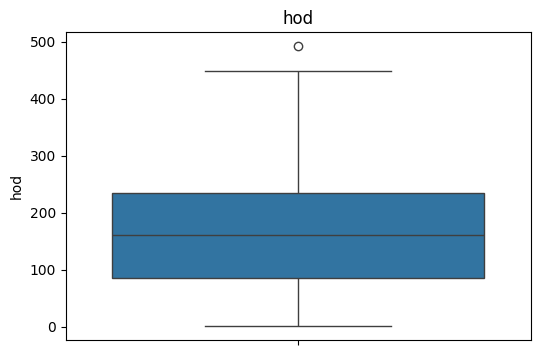

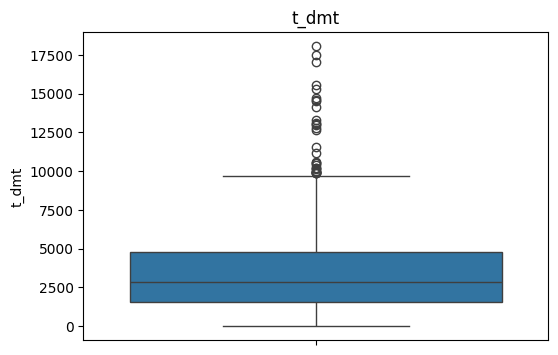

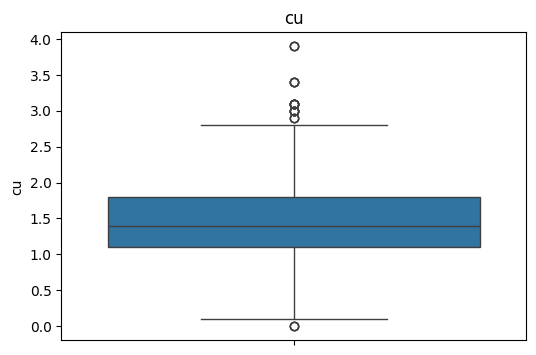

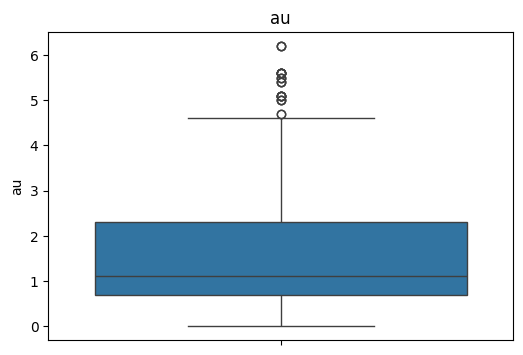

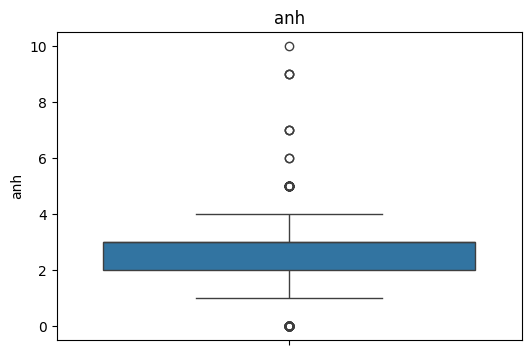

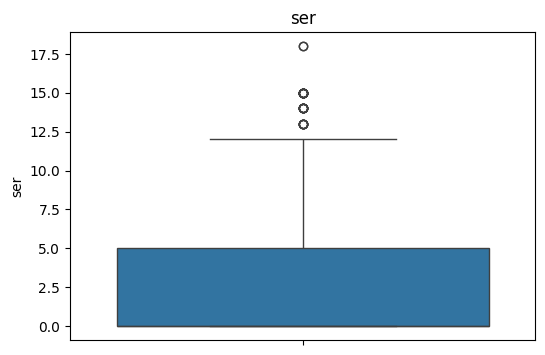

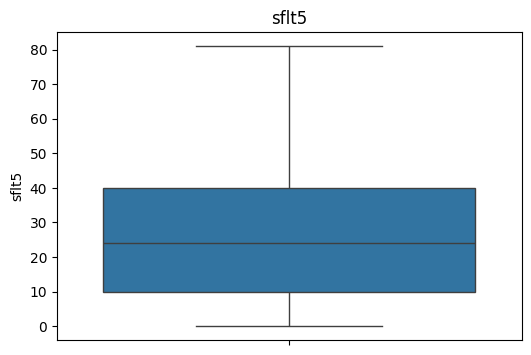

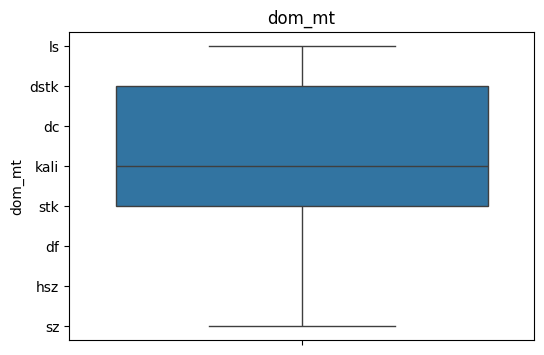

In [ ]:
numeric_field = [
  'hod',
  't_dmt',
  'cu',
  'au',
  'anh',
  'ser',
  'sflt5',
  'dom_mt'
]

for field in numeric_field:
  boxplot(preprocessed_2020_2025_df, field)


### [histogram] material type

In [ ]:
# # hst = [
'dom_mt'
]

attributes_data = {
    'columns': ["kali","stk","df","ls","hsz","dc","dstk","sz"],
    'colors' : ["#FFDAB9","#DB7093","#808000","#00CED1","#4B0082","#00FF00","#FF4500","#FFFF00"]
}

for dp in dps:
  dp_filtered_df = preprocessed_df[preprocessed_df['dp'] == dp].copy()
  histogram(dp_filtered_df, attributes_data)


SyntaxError: unmatched ']' (<ipython-input-1-bafff2b5942d>, line 3)

In [ ]:
'hod',
't_dmt',
'cu',
'au',
'anh',
'ser',
'sflt5',

### [histogram] fragmentasi

In [ ]:
# # @title
# # dps = preprocessed_df['dp'].unique().tolist()

# dps = [
# "P15-41S",
# "P17-42S",
# "P19-44N",
# "P24-23S",
# ]

# attributes_data = {
#     'columns': ["sflt5", "sf5-50", "sf50-1", "sf1-2", "sfgt2"],
#     'colors' : ["red", "yellow", "green", "blue", "pink"]
# }

# for dp in dps:
#   dp_filtered_df = preprocessed_df[preprocessed_df['dp'] == dp].copy()
#   dp_filtered_df = dp_filtered_df.sort_values(by=['pb'], ascending=[True])
#   histogram(dp_filtered_df, attributes_data)

In [ ]:
# for field in numeric_field:
#   before_after_boxplot_iqr(preprocessed_df, field)

In [ ]:
# heatmap(preprocessed_df[numeric_field])

In [ ]:
# heatmap with removed outlier value
# preprocessed_after_cleansing_outlier_df = iqr_filtered(preprocessed_df, numeric_field)
# heatmap(preprocessed_after_cleansing_outlier_df[numeric_field])

##3. Pisahin Masing-Masing Production Block / PB dari data_clean
maksud nya ini harus ada keterangan PB berapa - Lokasinya dimana.(contoh : PB1N, PB2S, dst)

jadi nanti ada beberapa sheet atau file data, sesuai lokasi Production Block.
*   sheet 1 = PB1S
*   sheet 2 - PB1N
*   sheet 3 - PB1C
*   sheet 4 = PB2S
*   sheet 5 - PB2N




## 4. Pisahin Masing-masing Type Event (Spill, Slide, Tidak ada event)
dari masing-masing PB, pisahkan jenis kejadian.
misal :

**PB1S**
*   spill (semua data dpid/drawpoint)
*   slide
*   tidak ada event

**PB2S**
*   spill
*   slide
*   tidak ada event

**PB1N**
*   spill
*   slide
*   tidak ada event

dan seterusnya
jadi masing-masing PB ada 3 sheet

# Count type Event
setelah dipisahin masing-masing PB dan event, hitung kejadian spill tiap drawpoint dan urutkan dari yang terbanyak sampai terkecil. ini harus tetap ada semua data nya. berurut aja ke bawah dari tahun pertama sampai tahun terkhir.